# Introduction
오늘 강의에서 우리는 Deep learning 모델을 최적화하는 다양한 방법들에 대해 배웠습니다.

이번 실습을 통해 강의에서 배웠던 개념들을 일부 구현하고 실험해보도록 하겠습니다.

이 노트북에서는 다음 내용들을 다룹니다.
- 즉시 실행(Eager execution)
- Optimizer

## Import

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from time import time
import math
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## 즉시 실행(Eager execution)
이번 실습에서는 **즉시 실행(Eager execution)** 을 이용해서 코드를 실행시켜보도록 하겠습니다.
즉시 실행은 TensorFlow를 대화형 명령 스타일 로 프로그래밍 할 수 있도록 해줍니다. 그래프 생성 없이 연산을 즉시 실행하기 때문에 직관적으로 실행하고 디버그할 수 있습니다.

간단히 말해서 placeholder와 Session 없이 코드를 짤 수 있게됩니다.

자세한 내용은 [Tensorflow 즉시 실행 (Eager Execution) 가이드](https://github.com/tgjeon/TF-Eager-Execution-Guide-KR)를 참고해주세요.

In [2]:
# Session
# x = tf.placeholder(tf.float32, shape=[1, 1])
# m = tf.matmul(x, x)
# with tf.Session() as sess:
#   print(sess.run(m, feed_dict={x: [[2.]]})) # -> [[4.]]

# Eager execution
tf.enable_eager_execution() # 반드시 프로그램 실행 전에 실행되어야 합니다.

x = [[2.]]
m = tf.matmul(x, x)

print(m)
print(m.numpy())

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)
[[4.]]


In [3]:
seed = 777
np.random.seed(seed)
tf.random.set_random_seed(seed)

## Dataset
Fashion MNIST 데이터를 이용해서 실험을 진행해보겠습니다.

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape([-1, 28*28]).astype(np.float32) / 255.
y_train = y_train.astype(np.int64)
x_test = x_test.reshape([-1, 28*28]).astype(np.float32) / 255.
y_test = y_test.astype(np.int64)

print(f"input shape: {x_train.shape}")
print(f"label shape: {y_train.shape}")

input shape: (60000, 784)
label shape: (60000,)


## Model 생성
베이스 라인으로 사용될 모델을 생성하겠습니다.

모델 생성 단계에서 weight initialization을 수행할 수 있습니다.
다양한 initializer를 [Tensorflow initializer docs](https://www.tensorflow.org/api_docs/python/tf/initializers)에서 찾아볼 수 있습니다.

In [5]:
class Model(object):
    """
    Fully connected 모델을 생성합니다.
    """
    def __init__(self, n_in, n_out, n_hidden_unit, n_hidden_layer):
        n_units = [n_in] + [n_hidden_unit] * n_hidden_layer + [n_out]
        # 주어진 크기의 모델을 생성합니다.
        self.weights, self.biases = [], []
        for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
            # weight initialization
            ## 1. 직접 입력
            # limit = math.sqrt(6 / n_in)
            # weight = tf.Variable(tf.random_uniform([n_in, n_out], -limit, limit))
            # bias = tf.Variable(tf.zeros([n_out]))
            ## 2. initializer 활용
            initializer = tf.glorot_uniform_initializer()
            weight = tf.Variable(initializer([n_in, n_out]))
            bias = tf.Variable(initializer([n_out]))
            # gradient를 계산하기 위해 학습 가능한 변수들을 저장해둡니다.
            self.weights.append(weight)
            self.biases.append(bias)

        self.variables = self.weights + self.biases
    def __call__(self, x):
        layer = x
        for i, (weight, bias) in enumerate(zip(self.weights, self.biases)): 
            layer = tf.matmul(layer, weight) + bias
            if i < len(self.weights) - 1:
                layer = tf.nn.relu(layer)
        y_hat = layer
        return y_hat
# Model Parameters
n_in = 28 * 28
n_out = 10
n_hidden_unit = 100
n_hidden_layer = 2

model = Model(n_in, n_out, n_hidden_unit, n_hidden_layer)

# model test
sample_x = tf.zeros([1, 28*28])
sample_y_hat = model(sample_x)
print(f"output tensor: {sample_y_hat}")

output tensor: [[-0.41847193 -0.27597618 -0.2123535  -0.20621337 -0.15156394 -0.67525434
  -0.59651184 -0.7019063   0.2169635   0.18257716]]


## Performance function
학습 평가를 위해 사용되는 함수들입니다.

In [6]:
def loss_fn(model, images, labels):
    logits = model(images)
    loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels)
    return loss

def accuracy_fn(model, images, labels):
    logits = model(images)
    prediction = tf.equal(tf.argmax(logits, -1), labels)
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    return accuracy

# gradient를 계산합니다.
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

## Training
생성된 모델과 fashion mnist 데이터를 이용해 학습을 진행해보도록 하겠습니다.


적절하다고 생각하는 batch_size를 정해서 **@TODO**를 채워주세요.

In [7]:
# Training Hyper-parameters
batch_size = 1024 #@TODO
iterations = len(x_train) // batch_size

epochs = 5
learning_rate = 1e-2

# 학습을 위해 데이터를 배치 크기로 나눕니다.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(1000).batch(batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


딥러닝 모델을 학습시키기 위해 사용되는 다양한 optimizer들이 있습니다.

가장 기본적인 optimizer로는 (Stochastic) Gridient Descent 알고리즘을 기반으로 한 GradientDescentOptimizer가 있고
대체로 가장 좋은 성능을 보인다고 알려진 optimizer는 강의에서 배운 AdamOptimizer가 있습니다.

더 많은 optimizer들을 확인하기 위해서는 [Tensorflow optimizer docs](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer)를 참고해주세요.

사용할 optimizer를 정해서 **@TODO**를 채워주세요.

In [8]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate) #@TODO

In [9]:
train_loss_history = []
train_acc_history = []
test_acc_history = []
start_time = time()
# Training
for epoch in range(epochs):
    for (idx, (images, labels)) in enumerate(train_dataset.take(iterations)):
        # gradient를 계산하고 optimizer를 이용해 back propagation을 수행합니다.
        grads = grad(model, images, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())
        
        # performance를 계산합니다
        train_loss = loss_fn(model, images, labels)
        train_accuracy = accuracy_fn(model, images, labels)
        test_accuracy = accuracy_fn(model, x_test, y_test)
        
        # 그래프를 그리기 위해 기록합니다.
        train_loss_history.append(train_loss.numpy())
        train_acc_history.append(train_accuracy.numpy())
        test_acc_history.append(test_accuracy.numpy())
        
        # 학습 과정을 출력합니다.
        if idx % 20 == 0 or idx == iterations - 1:
            print("Epoch: [%2d] [%5d/%5d] time: %4.4f, train_loss: %.8f, train_accuracy: %.4f, test_Accuracy: %.4f" \
                % (epoch + 1, idx + 1, iterations, time() - start_time, train_loss, train_accuracy,
                   test_accuracy))

Epoch: [ 1] [    1/   58] time: 0.4910, train_loss: 2.68508983, train_accuracy: 0.2520, test_Accuracy: 0.2318
Epoch: [ 1] [   21/   58] time: 8.2439, train_loss: 0.62143260, train_accuracy: 0.7646, test_Accuracy: 0.7410
Epoch: [ 1] [   41/   58] time: 15.8074, train_loss: 0.46683282, train_accuracy: 0.8330, test_Accuracy: 0.8057
Epoch: [ 1] [   58/   58] time: 22.2267, train_loss: 0.46504769, train_accuracy: 0.8320, test_Accuracy: 0.8170
Epoch: [ 2] [    1/   58] time: 22.7077, train_loss: 0.42527276, train_accuracy: 0.8438, test_Accuracy: 0.8208
Epoch: [ 2] [   21/   58] time: 30.1943, train_loss: 0.37962154, train_accuracy: 0.8652, test_Accuracy: 0.8363
Epoch: [ 2] [   41/   58] time: 33.1120, train_loss: 0.36164343, train_accuracy: 0.8701, test_Accuracy: 0.8375
Epoch: [ 2] [   58/   58] time: 34.0429, train_loss: 0.39202219, train_accuracy: 0.8623, test_Accuracy: 0.8389
Epoch: [ 3] [    1/   58] time: 34.1707, train_loss: 0.36366349, train_accuracy: 0.8799, test_Accuracy: 0.8450
Epo

## Plot Result
학습 과정을 그래프로 그려보겠습니다.

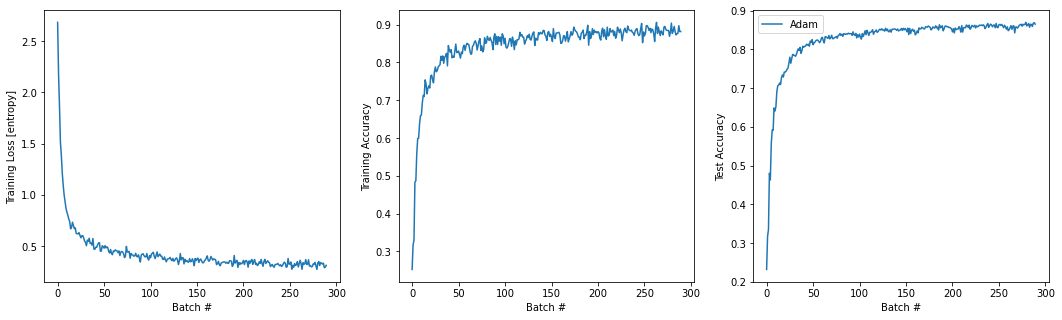

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_fn(labels, train_loss_histories, train_acc_histories, test_acc_histories):
    fig = plt.figure(figsize=(18,5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    for label, train_loss_history, train_acc_history, test_acc_history in zip(labels, train_loss_histories, train_acc_histories, test_acc_histories):
        ax1.plot(train_loss_history, label=str(label))
        ax2.plot(train_acc_history, label=str(label))
        ax3.plot(test_acc_history, label=str(label))
        
    ax1.set_xlabel('Batch #')
    ax1.set_ylabel('Training Loss [entropy]')
    ax2.set_xlabel('Batch #')
    ax2.set_ylabel('Training Accuracy')
    ax3.set_xlabel('Batch #')
    ax3.set_ylabel('Test Accuracy')
    plt.legend()
    plt.show()
plot_fn(['Adam'],[train_loss_history], [train_acc_history], [test_acc_history])

## Exercise
@TODO plot_fn을 이용해서 다양한 optimizer들의 학습 과정을 비교해보세요.

힌트1: 위 학습 loop를 또 다른 loop로 감싸보세요.

힌트2: 

optimizers={'sgd': tf.train.GradientDescentOptimizer(learning_rate),
            'sgd w/ nesterov': tf.train.MomentumOptimizer(learning_rate, momentum=0.3 ,use_nesterov=True),
            'adagrad': tf.train.AdagradOptimizer(learning_rate),
            'rmsprop': tf.train.RMSPropOptimizer(learning_rate),
            'adam': tf.train.AdamOptimizer(learning_rate)}

Using sgd
Epoch: [ 1] [    1/   58] time: 0.3734, train_loss: 0.28593788, train_accuracy: 0.8994, test_Accuracy: 0.8661
Epoch: [ 1] [   21/   58] time: 5.3238, train_loss: 0.27285540, train_accuracy: 0.8936, test_Accuracy: 0.8711
Epoch: [ 1] [   41/   58] time: 10.3037, train_loss: 0.28376383, train_accuracy: 0.9033, test_Accuracy: 0.8717
Epoch: [ 1] [   58/   58] time: 14.2787, train_loss: 0.29886359, train_accuracy: 0.8838, test_Accuracy: 0.8720
Epoch: [ 2] [    1/   58] time: 14.5995, train_loss: 0.27223679, train_accuracy: 0.9033, test_Accuracy: 0.8720
Epoch: [ 2] [   21/   58] time: 16.4223, train_loss: 0.26833433, train_accuracy: 0.8955, test_Accuracy: 0.8720
Epoch: [ 2] [   41/   58] time: 18.9396, train_loss: 0.28091449, train_accuracy: 0.9043, test_Accuracy: 0.8718
Epoch: [ 2] [   58/   58] time: 20.0478, train_loss: 0.29740539, train_accuracy: 0.8818, test_Accuracy: 0.8721
Epoch: [ 3] [    1/   58] time: 20.3210, train_loss: 0.27130941, train_accuracy: 0.9062, test_Accuracy: 

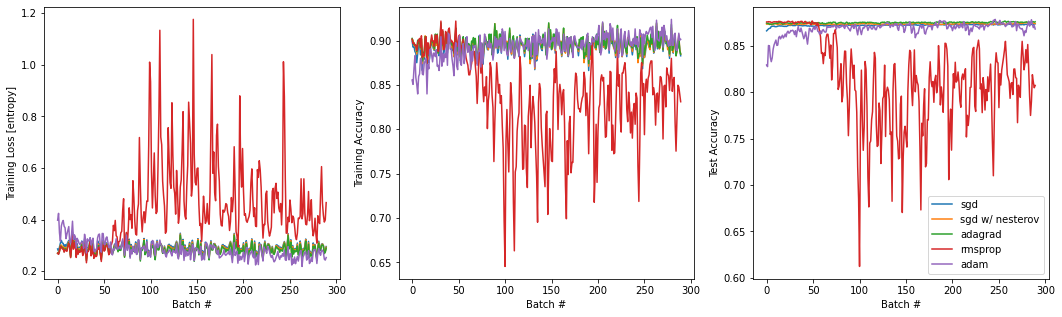

In [11]:
optimizers={'sgd': tf.train.GradientDescentOptimizer(learning_rate), 'sgd w/ nesterov': tf.train.MomentumOptimizer(learning_rate, momentum=0.3 ,use_nesterov=True), 'adagrad': tf.train.AdagradOptimizer(learning_rate), 'rmsprop': tf.train.RMSPropOptimizer(learning_rate), 'adam': tf.train.AdamOptimizer(learning_rate)}

train_loss_histories = []
train_acc_histories = []
test_acc_histories = []

for (opt_name, optimizer) in optimizers.items():
    print("Using {}".format(opt_name))

    train_loss_history = []
    train_acc_history = []
    test_acc_history = []
    start_time = time()

    # Training
    for epoch in range(epochs):
        for (idx, (images, labels)) in enumerate(train_dataset.take(iterations)):
            # gradient를 계산하고 optimizer를 이용해 back propagation을 수행합니다.
            grads = grad(model, images, labels)
            optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())
            
            # performance를 계산합니다
            train_loss = loss_fn(model, images, labels)
            train_accuracy = accuracy_fn(model, images, labels)
            test_accuracy = accuracy_fn(model, x_test, y_test)
            
            # 그래프를 그리기 위해 기록합니다.
            train_loss_history.append(train_loss.numpy())
            train_acc_history.append(train_accuracy.numpy())
            test_acc_history.append(test_accuracy.numpy())
            
            # 학습 과정을 출력합니다.
            if idx % 20 == 0 or idx == iterations - 1:
                print("Epoch: [%2d] [%5d/%5d] time: %4.4f, train_loss: %.8f, train_accuracy: %.4f, test_Accuracy: %.4f" \
                    % (epoch + 1, idx + 1, iterations, time() - start_time, train_loss, train_accuracy,
                    test_accuracy))

    train_loss_histories.append(train_loss_history)
    train_acc_histories.append(train_acc_history)
    test_acc_histories.append(test_acc_history)

plot_fn([key for key in optimizers], train_loss_histories, train_acc_histories, test_acc_histories)

## 심화
몇몇 optimizer의 경우 hyperparameter들이 있습니다.(eg. Adam: beta1=0.9, beta2=0.999, epsilon=1e-08)

weight initialization을 조정해보고 
optimizer와 optimizer의 hyperparameter를 조정하면서 가장 높은 test accuracy를 구해보세요.